# Configuration de l'environnement de travail 

## Package

In [1]:
# !pip install scikit-learn plotly
# !pip install plotly -U
# !pip install pandas  missingno matplotlib seaborn plotly

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import missingno as msno
#import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ppscore as pps
import numpy as np
import scipy.stats as stats 
from scipy.stats import chi2_contingency

## Folders 

In [3]:
# Définir le répertoire de travail de manière référentielle
def set_working_directory():
   
    # Obtenir le chemin absolu du notebook courant
    notebook_path = os.path.abspath('.')
    
    # Définir le répertoire racine du projet 
    # (en remontant d'un ou plusieurs niveaux si nécessaire)
    project_root = os.path.dirname(notebook_path)
    
    # Définir les sous-répertoires
    data_dir = os.path.join(project_root, 'Data', 'Raw')
    output_dir = os.path.join(project_root, 'Data', 'Processed')
    
    # Créer les répertoires s'ils n'existent pas
    #os.makedirs(data_dir, exist_ok=True)
    #os.makedirs(output_dir, exist_ok=True)
    
    return {
        'project_root': project_root,
        'data_dir': data_dir,
        'output_dir': output_dir
    }


In [4]:
dirs  = set_working_directory()
print('project_root : ', dirs['project_root'],'data_dir : ', dirs['data_dir'], 'output_dir : ', dirs['output_dir'])

project_root :  c:\Users\LENOVO\Desktop\House_Price_Prediction data_dir :  c:\Users\LENOVO\Desktop\House_Price_Prediction\Data\Raw output_dir :  c:\Users\LENOVO\Desktop\House_Price_Prediction\Data\Processed


# Data Understanding

### Chargement des données et traitements préliminaires 

Vu que certaines variables ont la modalité 'NA' qui par défaut est considéré comme valeur manquante pandas, les paramètres par défaut sont modifiés à l'importation de manière à ce que les 'NA' ne sont pas considérés comme valeurs manquantes (naN de pandas)

In [5]:
data_file_path = os.path.join(dirs['data_dir'], 'train.csv')
data = pd.read_csv(data_file_path, na_values=['NA', 'N/A', 'null', ''],keep_default_na=False)
data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [6]:
data.shape

(1460, 81)

In [7]:
# type des variables
data.info()

# Définir la variable Id comme identifiant 
data = data.set_index('Id')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

<Axes: >

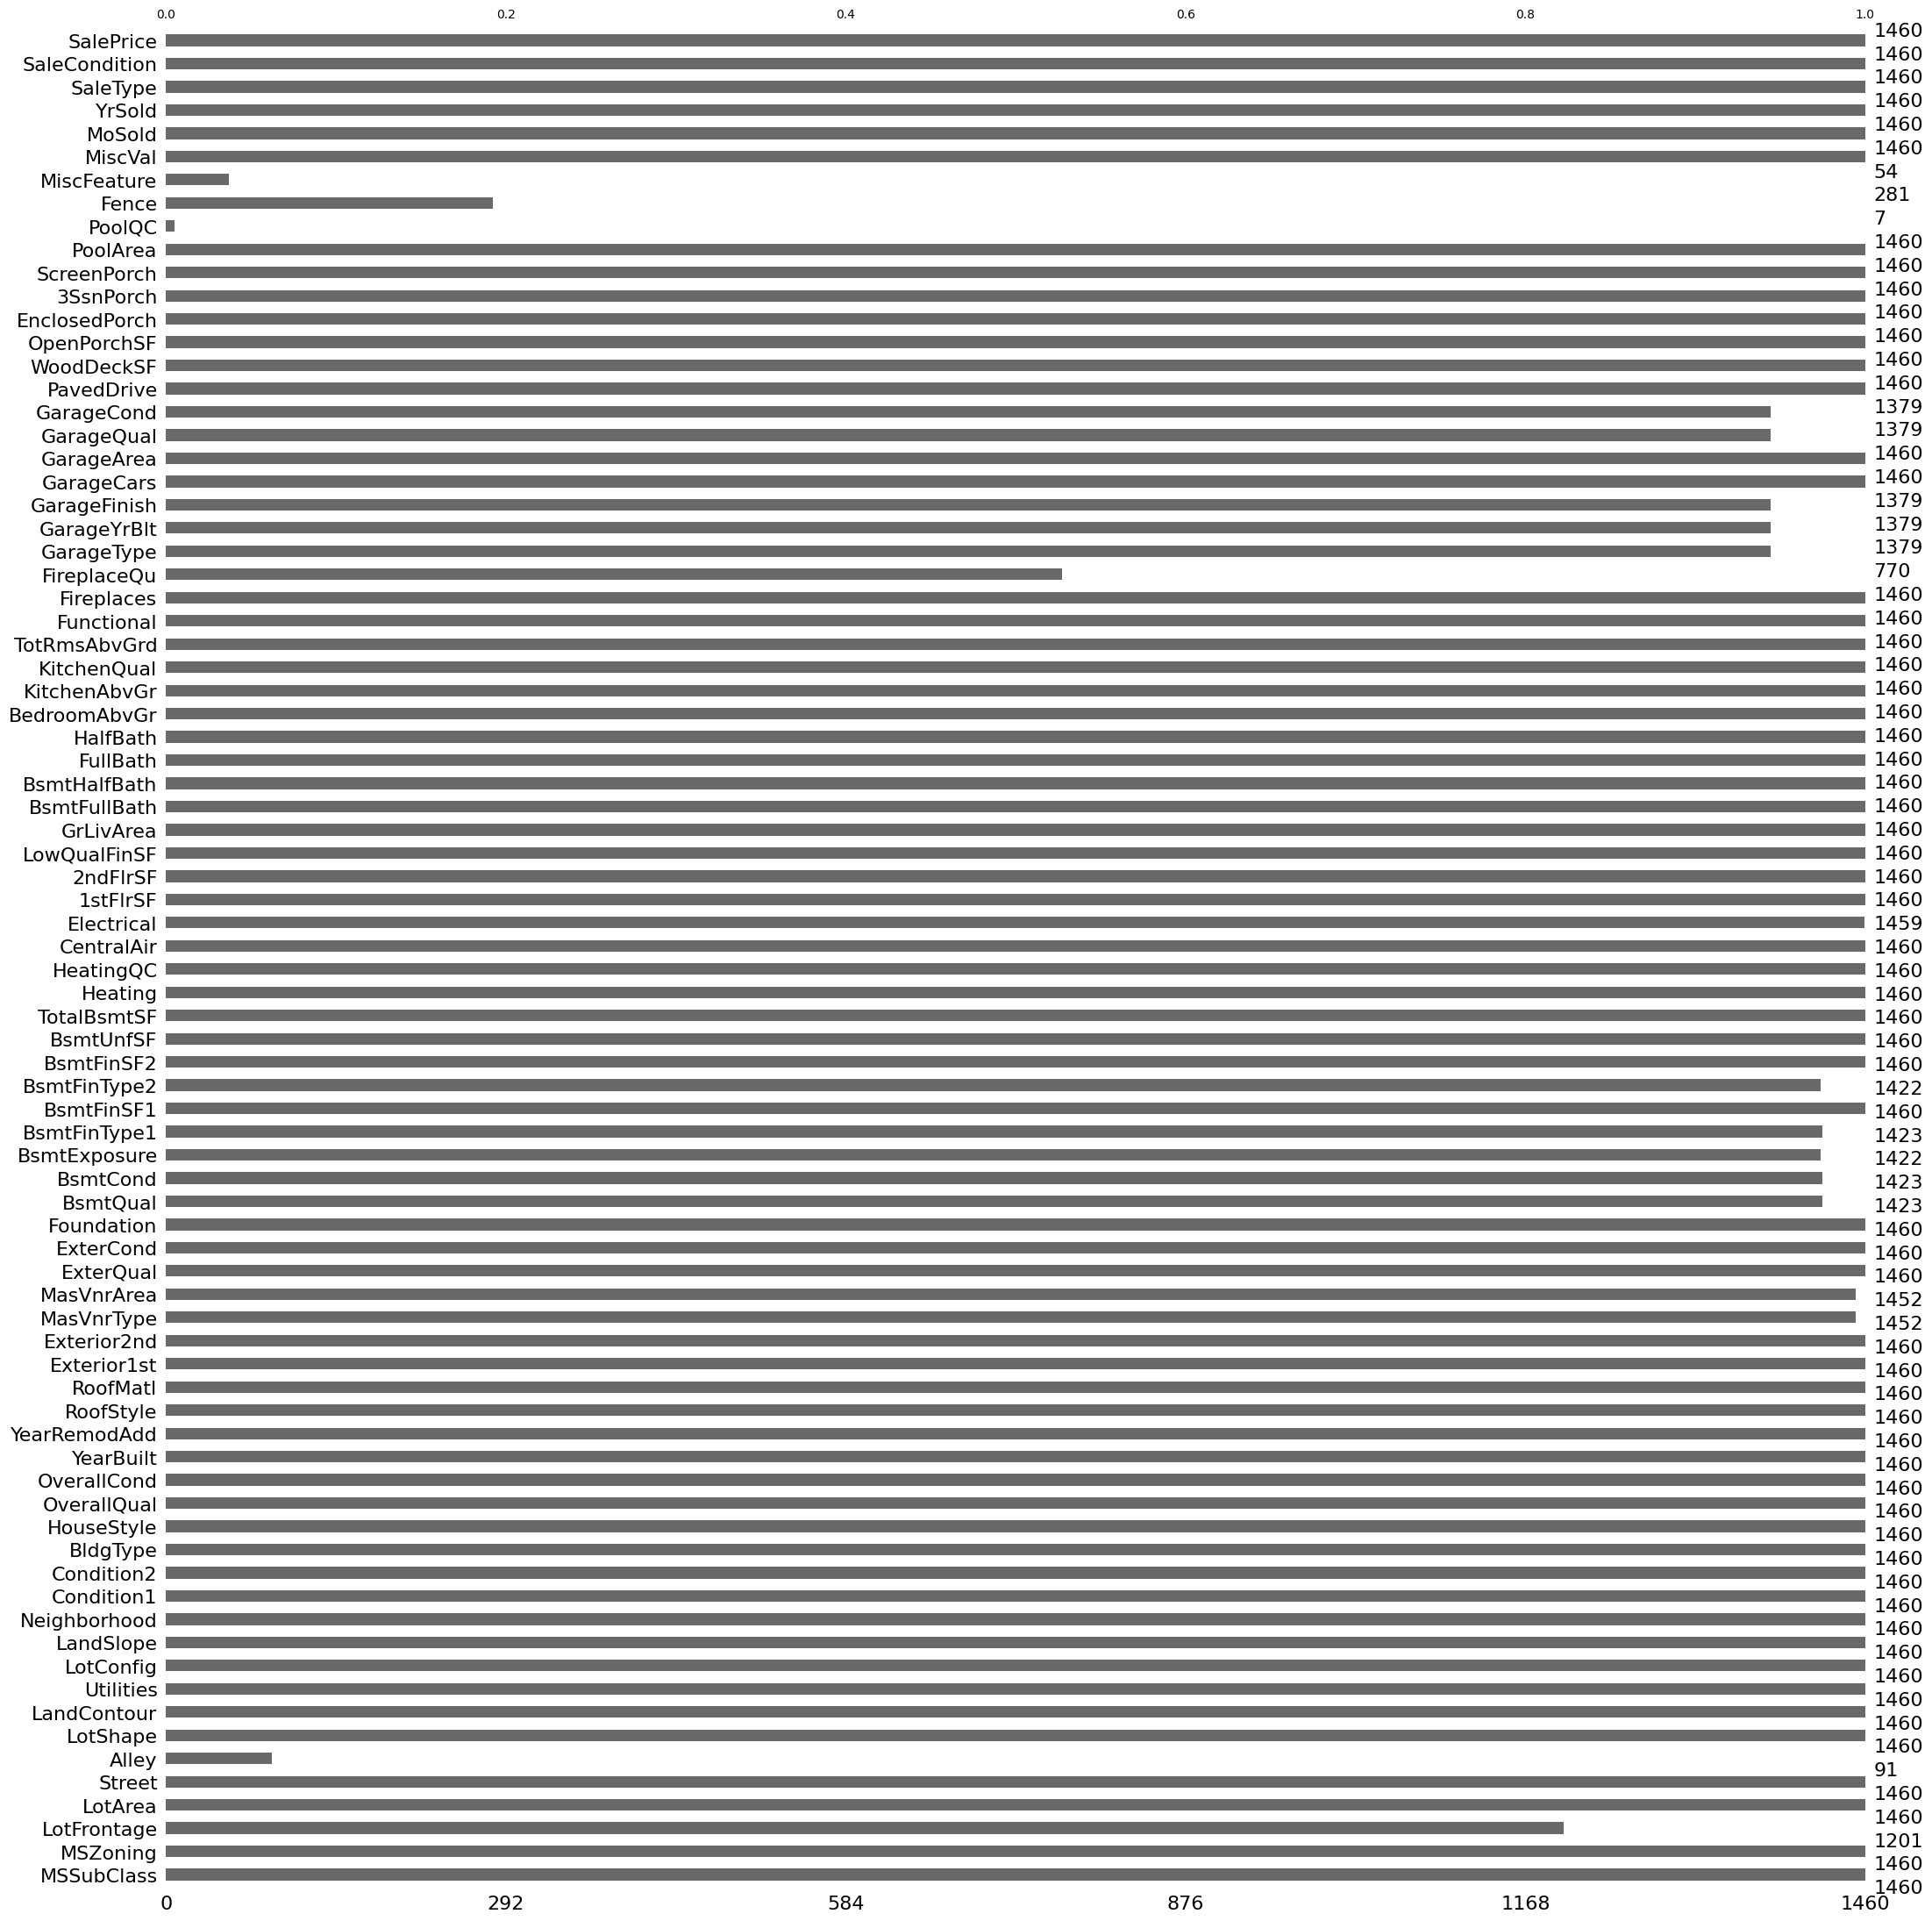

In [8]:
# Détection dees valeurs manquantes 
msno.bar(data,filter="top")

Cette partie gère et uniformise les types des variables 

In [9]:
# Convertir la colonne des dates en type datetime
#data['E'] = pd.to_datetime(data['E'], errors='coerce')

# Identifier les types de données
types_dict = data.dtypes.apply(lambda x: x.name).to_dict()

# Grouper les colonnes par type
grouped_columns = {}
for col, dtype in types_dict.items():
    grouped_columns.setdefault(dtype, []).append(col)

# Afficher les types et les colonnes correspondantes
for dtype, cols in grouped_columns.items():
    print(f"Type : {dtype}")
    print(f"Colonnes : {cols}")
    print()


Type : int64
Colonnes : ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

Type : object
Colonnes : ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'Gara

In [10]:
o_num = [
    "OverallQual", "OverallCond",
    

    "MSSubClass"
]
o_n_num = ['LandSlope',
                       "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC","BsmtExposure","BsmtFinType1", "BsmtFinType2",
                       "GarageFinish","GarageQual","GarageCond","PavedDrive","PoolQC","Fence",
                       "Functional","KitchenQual","HouseStyle","MSZoning"]
n_o = ['LotShape', 'Street', 'Alley', 'Neighborhood','Condition1', 'Condition2','LandContour','Utilities', 'LotConfig','SaleType', 'SaleCondition',
               "RoofMatl", "Foundation", "Heating", "Electrical","MasVnrType",
               "GarageType","Exterior1st","Exterior2nd",
               "MiscFeature","RoofStyle","BldgType"]
cont = ['LotFrontage', 'LotArea',
        "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
        "GarageCars","GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea",
        "TotRmsAbvGrd", "KitchenAbvGr","BedroomAbvGr","HalfBath","FullBath", "BsmtHalfBath","BsmtFullBath","GrLivArea","TotalBsmtSF"]
boul = [
    "CentralAir"
]
dat = ['YearBuilt', 'YearRemodAdd', 'MoSold', 'YrSold',
       
       "GarageYrBlt"]

Formatage des variables selon leurs typage

In [11]:
# Copie du DataFrame original pour éviter les modifications directes
data_f = data.copy()

# Formatage des variables ordinales numériques
for col in o_num:
    data_f [col] = pd.Categorical(data_f[col])

# Formatage des variables ordinales non numériques
for col in o_n_num:
    data_f [col] = pd.Categorical(data_f[col])

# Formatage des variables non ordinales
for col in n_o:
    data_f [col] = pd.Categorical(data_f[col])

# Formatage des variables continues
for col in cont:
    data_f [col] = data_f [col].astype(float)

# Formatage des variables booléennes
for col in boul:
    data_f [col] = data_f [col].astype(bool)

# Formatage des variables de date
for col in dat:
    data_f [col] = pd.to_datetime(data_f [col])

# Data preparation

### Séparation des données 

D'abord les données train et test sont séparés afin d'assurer une entière indépendance entre ces deux

In [12]:
data = pd.read_csv(data_file_path, na_values=['NA', 'N/A', 'null', ''],keep_default_na=False)

In [13]:
# Collecte des variables ayant des valeurs manquantes 
NA_var = [col for col in data.columns if data[col].isna().any()]

# Nombre de valeurs manquantes pour les variables concernées
NA_var_counts = data.isna().sum()
print(NA_var_counts[NA_var_counts > 0])

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [14]:
# Fonction pour charger et séparer les données
def prepare_data(data, test_size=0.2, random_state=42):

    # Séparer les features et la target
    X = data.drop('SalePrice', axis=1)  # Remplacez 'target' par votre colonne cible
    y = data['SalePrice']
    
    # Séparer en données d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test


In [15]:

# Préparer les données
X_train, X_test, y_train, y_test = prepare_data(data)

# Quelques informations sur les jeux de données
print("Taille des données d'entraînement:", X_train.shape)
print("Taille des données de test:", X_test.shape)

Taille des données d'entraînement: (1168, 80)
Taille des données de test: (292, 80)


In [16]:
data_train = pd.concat([X_train, y_train], axis=1)


### Traitement des variables dates 

In [17]:
for col in dat:
    data_train [col] = pd.to_datetime(data_train[col])

In [18]:
# création de la variable durée de la maison 
data_train['Dure_house'] = data_train['YrSold'] - data_train['YearRemodAdd']
data_train['Dure_house'] = pd.to_numeric(data_train['Dure_house'])
data_train['Dure_garage'] = data_train['YrSold'] -data_train['GarageYrBlt']
data_train["Dure_garage"] = pd.to_numeric(data_train["Dure_garage"])

### traitement des valeurs manquantes 

<Axes: >

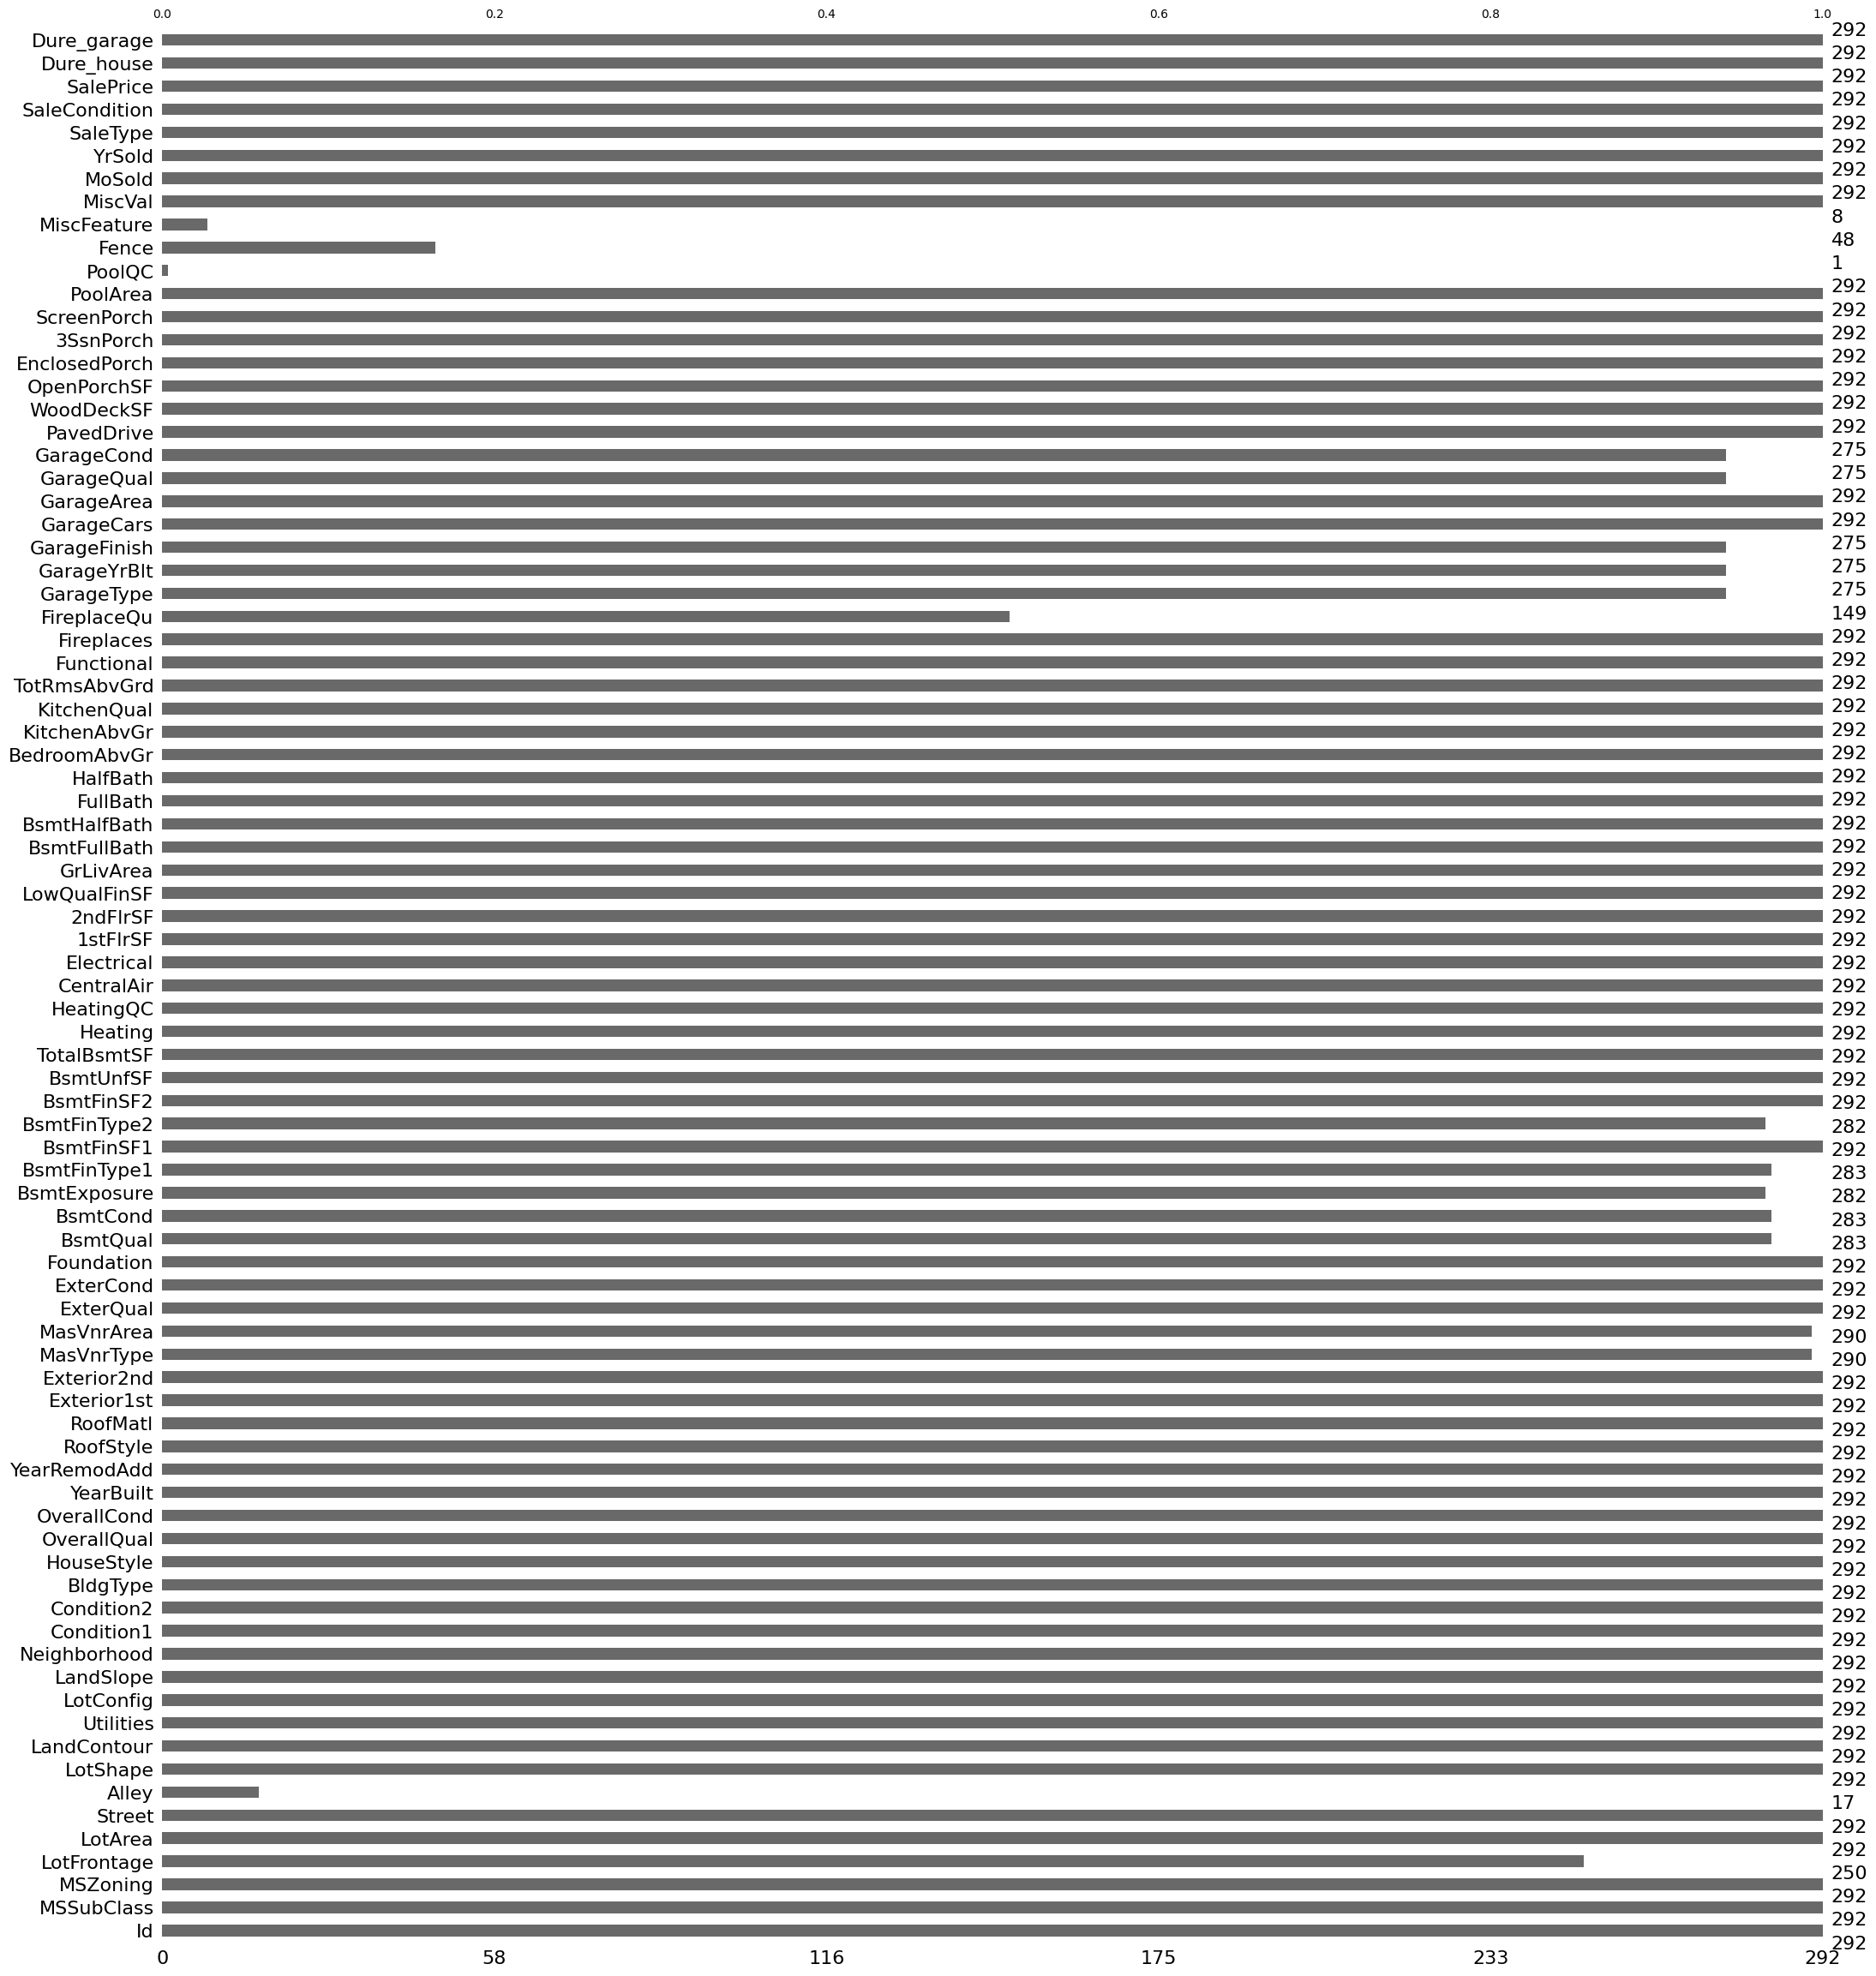

In [19]:
# Détection dees valeurs manquantes 
msno.bar(data_train,filter="top")

Dans la base de données certaines variables ont la modalité 'NA' et donc à l'importation ces modalités ont été considéré comme valeurs manquantes par pandas au même titre que les vrais valeurs manquantes 'NA' présentes sur d'autres variables.

Dans cette partie 'les fausses valeurs manquantes sont corrigées'. Plus bas se fera le traitement des valeurs manquantes.

<Axes: >

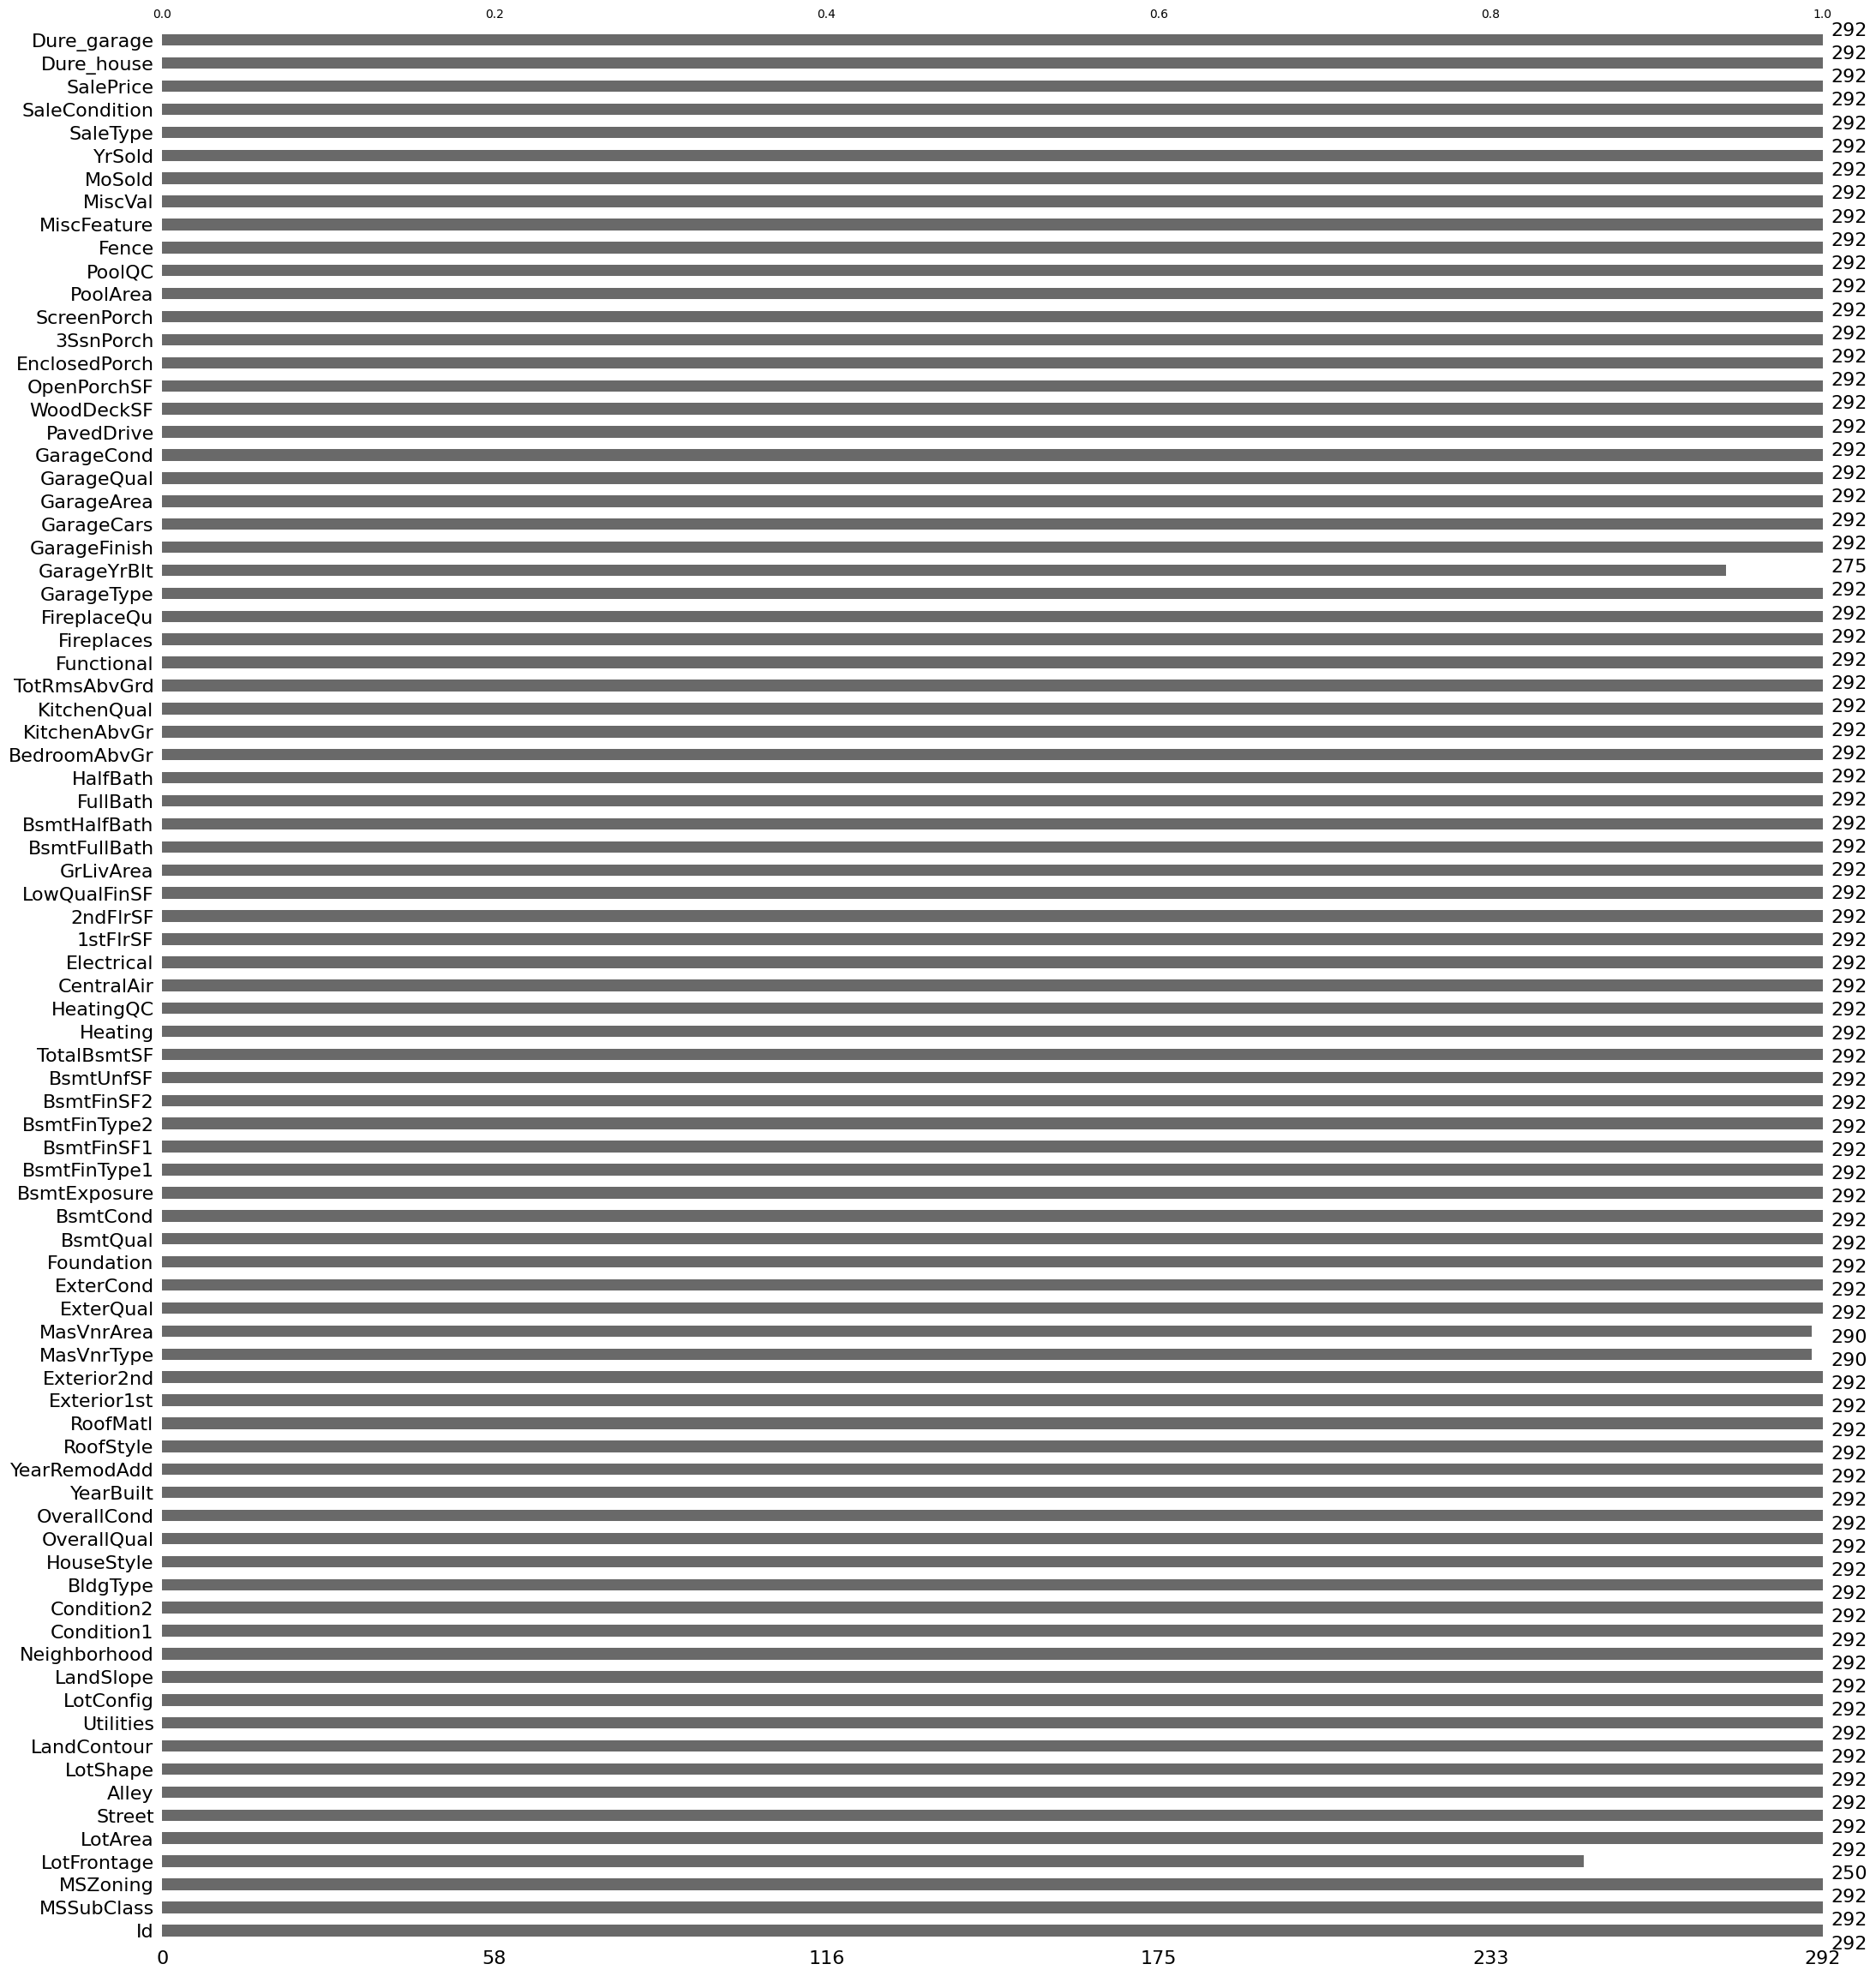

In [20]:
NA_fake_var = ["BsmtQual", "BsmtCond", "BsmtExposure",
               "BsmtFinType1", "BsmtFinType2",
               'GarageQual','GarageType', 'GarageFinish','GarageCond','PoolQC','Fence',
                'MiscFeature',
                'Alley','FireplaceQu' ]
data_train[NA_fake_var ] = data_train[NA_fake_var].fillna("nonappli")

# revisualisation des valeurs manquantes 
msno.bar(data_train,filter="top")

In [21]:
# Collecte des variables ayant des valeurs manquantes 
NA_var = [col for col in data_train.columns if data_train[col].isna().any()]

# Nombre de valeurs manquantes pour les variables concernées
NA_var_counts = data_train.isna().sum()
print(NA_var_counts[NA_var_counts > 0])

LotFrontage    42
MasVnrType      2
MasVnrArea      2
GarageYrBlt    17
dtype: int64


Remplissange des valeurs manquantes 

#### LotFrontage
Cette variable rensigne la longueur en pieds linéaires de la rue connectée à la propriété. Les valeurs manquantes (217) indiquant l'absence de cette dernière souligne alors un cas non souhaitable. A contrario, il est bon que cette longueur soit proche de 0. Par conséquent, aussi par insuffisante de métadonnées sur les critères de considération d'absence de la rue connectée, nous imputont ces valeurs manquantes par la valeur maximale de LotFrontage.

In [22]:
print(max(data_train["LotFrontage"]), min(data_train["LotFrontage"]))

174.0 21.0


In [23]:
data_train["LotFrontage"] = data_train["LotFrontage"].fillna(max(data_train["LotFrontage"]))

#### MasVnrArea et MasVnrType
MasVnrArea rensigne sur les maisons ne disposant pas de plaçage de maconnerie. Etant donnée que la situation pas de placage de maconnerie est déjà prise en compte (modalité None), nous allons remplacer les valeurs manquantes de MasVnrType par le mode et celle de MasVnrArea par la médiane des sur la valeur modale de MasVnrType. 

In [24]:
valeur_modale = data_train['MasVnrType'].mode()[0]

mediane_conditionnelle = data_train[data_train['MasVnrType'] == valeur_modale]['MasVnrArea'].median()

data_train['MasVnrType'] = data_train['MasVnrType'].fillna(valeur_modale)
data_train['MasVnrArea'] = data_train['MasVnrArea'].fillna(mediane_conditionnelle)

#### Electrical
Cette variable qualitative ne contient qu'une seule valeur manquante. Sans grand risque de modifier la distribution de cette variable, nous remplacons cette valeur manquante par le mode.

In [25]:
data_train["Electric"] = data_train["Electrical"].fillna(data_train["Electrical"].mode()[0])

### Dure_garage 
Une petite durée du garage est souhaitée. Nous donnons donc aux valeurs manquantes correspondante à l'absence de garage, la plus grade durée.


In [26]:
data_train["Dure_garage"] = data_train["Dure_garage"].fillna(max(data_train["Dure_garage"]))
#data_train["Dure_garage"] = pd.to_numeric(data_train["Dure_garage"])

### Suppression des variables dates 

In [27]:
data_train = data_train.drop(dat, axis=1)

Vérification des valeurs manquantes 

<Axes: >

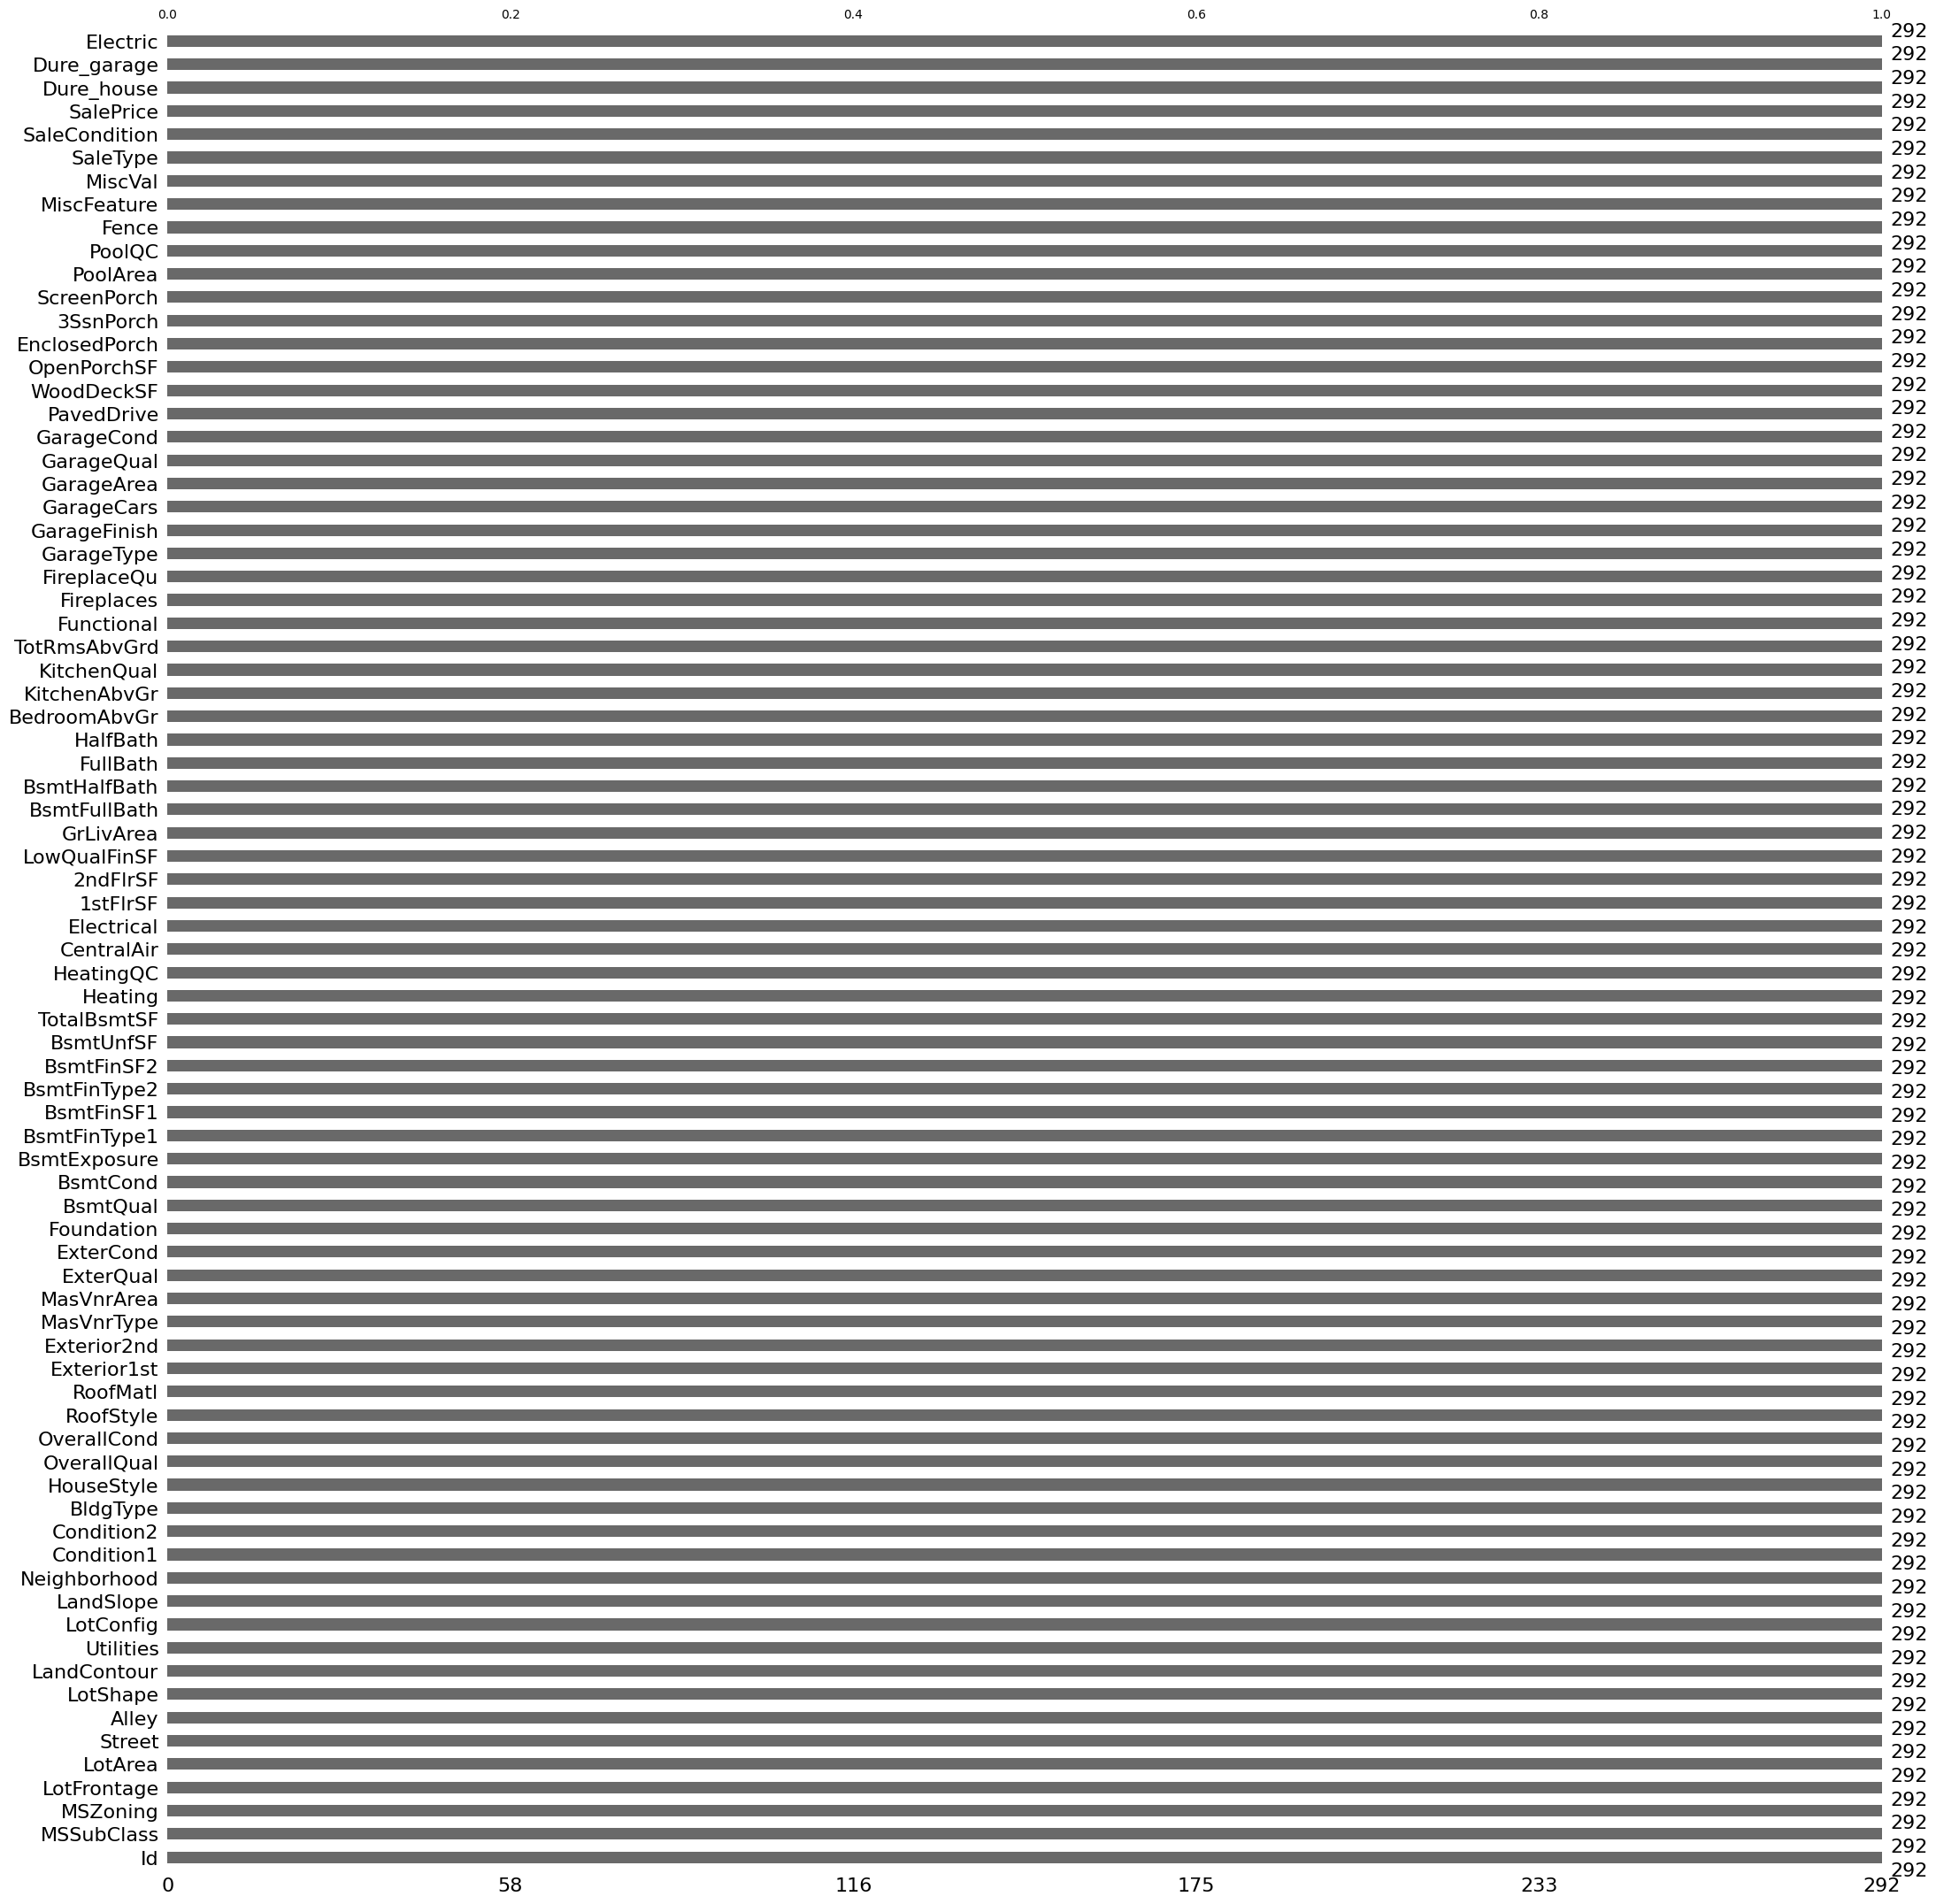

In [28]:
# revisualisation des valeurs manquantes 
msno.bar(data_train,filter="top")

### Sélection des varibles ayant un fort pouvoir prédictif avec PPscore

In [29]:
def calculer_pouvoir_predictif(df, target_variable, seuil=0.1):
    """
    Calcule le pouvoir prédictif de toutes les variables par rapport à une variable cible.
    
    Paramètres:
    -----------
    df : pandas.DataFrame
        Le DataFrame contenant les données
    
    target_variable : str
        Le nom de la variable cible à prédire
    
    seuil : float, optionnel
        Seuil minimal du pouvoir prédictif (défaut: 0.1)
    
    Retourne:
    ---------
    tuple : (pandas.DataFrame, list)
        - Un DataFrame avec les variables et leurs pouvoirs prédictifs
        - Une liste des variables ayant un pouvoir prédictif supérieur au seuil
    """
    # Créer une copie du DataFrame pour éviter les modifications
    df_prepare = df.copy()
    
    # Calculer les scores PPS pour toutes les variables
    pps_scores = []
    for col in df_prepare.columns:
        if col != target_variable:
            try:
                score = pps.score(df_prepare, col, target_variable)['ppscore']
                pps_scores.append({'variable': col, 'pouvoir_predictif': score})
            except:
                # Gérer les cas où le calcul du PPS échoue
                pass
    
    # Créer un DataFrame à partir des scores
    df_pouvoir_predictif = pd.DataFrame(pps_scores)
    
    # Trier par pouvoir prédictif décroissant
    df_pouvoir_predictif = df_pouvoir_predictif.sort_values('pouvoir_predictif', ascending=False)
    
    # Sélectionner les variables ayant un pouvoir prédictif supérieur au seuil
    variables_significatives = df_pouvoir_predictif[
        df_pouvoir_predictif['pouvoir_predictif'] > seuil
    ]['variable'].tolist()
    
    return df_pouvoir_predictif, variables_significatives

In [30]:
# Exemple d'utilisation

# Définir la variable cible
target_variable = "SalePrice"

# Calculer le pouvoir prédictif

df_pouvoir_predictif, variables_significatives = calculer_pouvoir_predictif(
    data_train, 
    target_variable, 
    seuil=0.08# Vous pouvez modifier ce seuil
)

# Afficher le DataFrame des pouvoirs prédictifs
print("Tableau des pouvoirs prédictifs :")
print(df_pouvoir_predictif)

# Afficher les variables significatives
print("\nVariables avec un pouvoir prédictif significatif :")
print(variables_significatives)
print(len(variables_significatives))



Tableau des pouvoirs prédictifs :
        variable  pouvoir_predictif
17   OverallQual           0.450562
25     ExterQual           0.334009
12  Neighborhood           0.331928
58    GarageCars           0.313181
28      BsmtQual           0.280636
..           ...                ...
40    Electrical           0.000000
41      1stFlrSF           0.000000
42      2ndFlrSF           0.000000
43  LowQualFinSF           0.000000
77      Electric           0.000000

[78 rows x 2 columns]

Variables avec un pouvoir prédictif significatif :
['OverallQual', 'ExterQual', 'Neighborhood', 'GarageCars', 'BsmtQual', 'KitchenQual', 'GarageArea', 'FullBath', 'TotRmsAbvGrd', 'GarageFinish', 'Foundation', 'FireplaceQu', 'GarageType', 'Dure_house', 'MasVnrType', 'MSSubClass', 'BsmtFinType1', 'GrLivArea']
18


In [31]:
def visualiser_ppscore(df_pouvoir_predictif, top_n=15):
    """
    Visualise les PPS scores avec un graphique à barres horizontal.
    
    Paramètres:
    -----------
    df_pouvoir_predictif : pandas.DataFrame
        DataFrame contenant les variables et leurs pouvoirs prédictifs
    
    top_n : int, optionnel
        Nombre de variables à afficher (défaut: 15)
    """
    # Sélectionner les top N variables
    top_variables = df_pouvoir_predictif.head(top_n)
    
    # Créer le graphique
    plt.figure(figsize=(12, 8))
    
    # Graphique à barres horizontal avec palette de couleurs
    sns.barplot(
        x='pouvoir_predictif', 
        y='variable', 
        data=top_variables,
        palette='viridis'  # Palette de couleurs attrayante
    )
    
    plt.title('Top des Variables par Pouvoir Prédictif', fontsize=16)
    plt.xlabel('Predictive Power Score', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    plt.tight_layout()
    plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15588\302567326.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


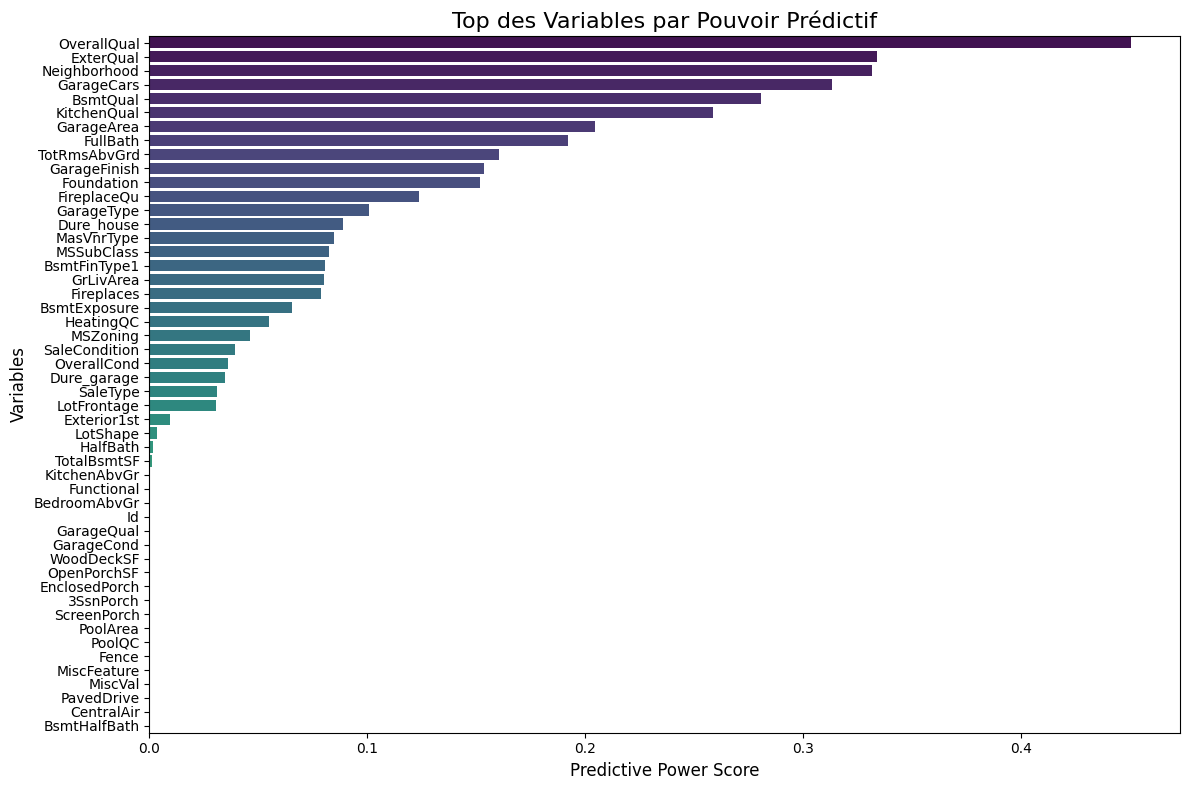

In [32]:
visualiser_ppscore(df_pouvoir_predictif, 50)

### Recodage des variables 

#### Type des variables sélectionnées

In [33]:
o_num = list(set(o_num) & set(variables_significatives))
o_n_num = list(set(o_n_num) & set(variables_significatives))
n_o = list(set(n_o) & set(variables_significatives))
cont = list(set(cont) & set(variables_significatives))
cont.extend(['Dure_house', 'Dure_garage'])
boul = list(set(boul) & set(variables_significatives))

In [34]:
# Liste de listes avec des noms associés
listes = {
    "o_num": o_num,
    "o_n_num": o_n_num,
    "cont": cont, 
    "n_o": n_o, 
    "boul": boul, 
}

# Parcourir chaque liste par son nom et ses éléments
for nom_liste, liste in listes.items():
    print(f"Éléments de {nom_liste} :")
    print(liste)
    print()

Éléments de o_num :
['OverallQual', 'MSSubClass']

Éléments de o_n_num :
['BsmtFinType1', 'KitchenQual', 'BsmtQual', 'GarageFinish', 'ExterQual']

Éléments de cont :
['GarageArea', 'GarageCars', 'TotRmsAbvGrd', 'FullBath', 'GrLivArea', 'Dure_house', 'Dure_garage']

Éléments de n_o :
['GarageType', 'Neighborhood', 'MasVnrType', 'Foundation']

Éléments de boul :
[]



#### liaison de variables qualitatives

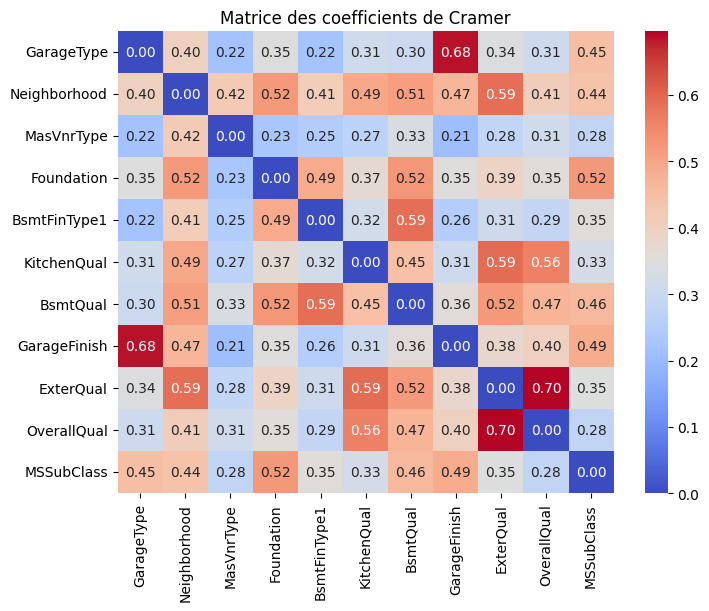

In [35]:
#Fonction pour calculer le coefficient de Cramér
def cramers_v(table):
    """Calculer le coefficient de Cramér pour une table de contingence"""
    chi2 = chi2_contingency(table)[0]
    n = table.sum().sum()
    min_dim = min(table.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

# Initialiser une matrice vide pour stocker les résultats
variables = n_o+o_n_num+o_num
n = len(variables)
cramers_matrix = pd.DataFrame(np.zeros((n, n)), index=variables, columns=variables)

# Remplir la matrice des coefficients de Cramér
for var1 in variables:
    for var2 in variables:
        if var1 != var2:
            table = pd.crosstab(data_train[var1], data_train[var2])
            cramers_matrix.loc[var1, var2] = cramers_v(table)

# Visualisation de la matrice avec une heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cramers_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Matrice des coefficients de Cramer")
plt.show()

In [36]:

def test_liaison_qualitatives(df, variables):
    """
    Réalise des tests de liaison pour toutes les paires de variables qualitatives
    
    Paramètres :
    - df : DataFrame pandas
    - variables : liste des noms des variables à tester
    """
    resultats = {}
    
    # Tests pour chaque paire de variables
    for i in range(len(variables)):
        for j in range(i+1, len(variables)):
            var1, var2 = variables[i], variables[j]
            
            # Tableau de contingence
            contingence = pd.crosstab(df[var1], df[var2])
            
            # Test du Chi-deux
            chi2, p_value_chi2, ddl, freq_theoriques = stats.chi2_contingency(contingence)
            
            # V de Cramer
            n = contingence.sum().sum()
            min_dim = min(contingence.shape) - 1
            v_cramer = np.sqrt(chi2 / (n * min_dim))
        
            
            resultats[(var1, var2)] = {
                'Chi2': chi2,
                'V_Cramer': v_cramer
            }
    
    return resultats

In [37]:
# Exemple d'utilisation

resultats = test_liaison_qualitatives(data_train, n_o+o_n_num+o_num)

# Affichage des résultats
for (var1, var2), stats_test in resultats.items():
    if stats_test['V_Cramer'] > 0.5 :
        print(f"Liaison entre {var1} et {var2}")
        print(f"Chi2 : {stats_test['Chi2']:.2f}")
        print(f"V de Cramer : {stats_test['V_Cramer']:.2f}")
   

Liaison entre GarageType et GarageFinish
Chi2 : 410.87
V de Cramer : 0.68
Liaison entre Neighborhood et Foundation
Chi2 : 315.61
V de Cramer : 0.52
Liaison entre Neighborhood et BsmtQual
Chi2 : 306.08
V de Cramer : 0.51
Liaison entre Neighborhood et ExterQual
Chi2 : 303.05
V de Cramer : 0.59
Liaison entre Foundation et BsmtQual
Chi2 : 321.65
V de Cramer : 0.52
Liaison entre Foundation et MSSubClass
Chi2 : 318.30
V de Cramer : 0.52
Liaison entre BsmtFinType1 et BsmtQual
Chi2 : 402.53
V de Cramer : 0.59
Liaison entre KitchenQual et ExterQual
Chi2 : 304.93
V de Cramer : 0.59
Liaison entre KitchenQual et OverallQual
Chi2 : 274.80
V de Cramer : 0.56
Liaison entre BsmtQual et ExterQual
Chi2 : 236.11
V de Cramer : 0.52
Liaison entre ExterQual et OverallQual
Chi2 : 423.79
V de Cramer : 0.70


#### suppression des variables liés

In [38]:
o_n_num_s = ["BsmtFinType1", "KitchenQual","ExterQual"]
n_o_s = ["Exterior2nd", "Foundation","GarageType"]
for o in o_n_num_s : 
    o_n_num.remove(o)
for o in n_o_s : 
    n_o.remove(o)


ValueError: list.remove(x): x not in list

#### liaison de variables quantitatives

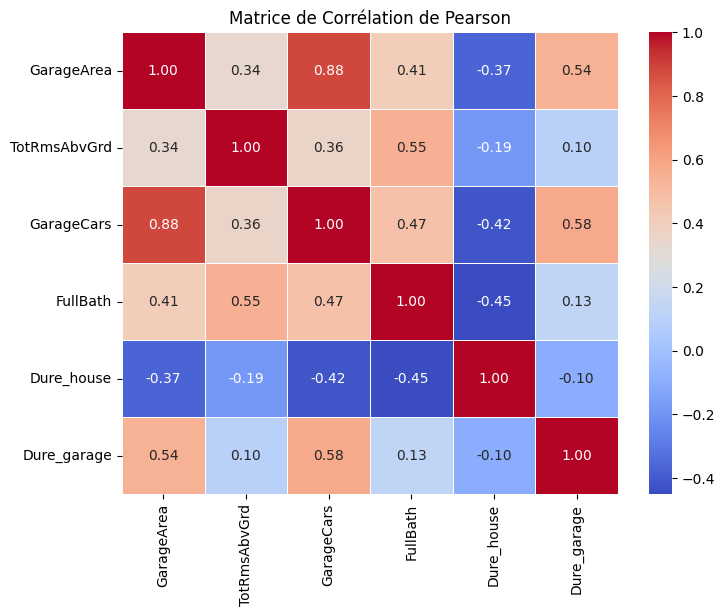

Variables ayant une corrélation supérieure à 0.7 :

              GarageArea  TotRmsAbvGrd  GarageCars  FullBath  Dure_house  \
GarageArea       1.00000           NaN     0.88255       NaN         NaN   
TotRmsAbvGrd         NaN           1.0         NaN       NaN         NaN   
GarageCars       0.88255           NaN     1.00000       NaN         NaN   
FullBath             NaN           NaN         NaN       1.0         NaN   
Dure_house           NaN           NaN         NaN       NaN         1.0   
Dure_garage          NaN           NaN         NaN       NaN         NaN   

              Dure_garage  
GarageArea            NaN  
TotRmsAbvGrd          NaN  
GarageCars            NaN  
FullBath              NaN  
Dure_house            NaN  
Dure_garage           1.0  


In [357]:

# Étape 1 : Calculer la matrice de corrélation de Pearson
correlation_matrix = data_train[cont].corr()

# Étape 2 : Visualiser la matrice de corrélation avec une heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matrice de Corrélation de Pearson")
plt.show()

# Étape 3 : Extraire les variables ayant un coefficient de corrélation supérieur à un seuil 
threshold = 0.7
high_correlation = correlation_matrix[correlation_matrix > threshold]

# Afficher les variables fortement corrélées
print("Variables ayant une corrélation supérieure à", threshold, ":\n")
print(high_correlation)


In [358]:
cont.remove("GarageArea")

In [359]:
# Liste de listes avec des noms associés
listes = {
    "o_num": o_num,
    "o_n_num": o_n_num,
    "cont": cont, 
    "n_o": n_o, 
    "boul": boul, 
}

# Parcourir chaque liste par son nom et ses éléments
for nom_liste, liste in listes.items():
    print(f"Éléments de {nom_liste} :")
    print(liste)
    print()

Éléments de o_num :
['MSSubClass', 'OverallQual']

Éléments de o_n_num :
['GarageFinish', 'BsmtQual', 'HeatingQC']

Éléments de cont :
['TotRmsAbvGrd', 'GarageCars', 'FullBath', 'Dure_house', 'Dure_garage']

Éléments de n_o :
['Exterior1st', 'Neighborhood']

Éléments de boul :
[]



#### recodage des variables ordinales non numériques

In [360]:
def label_encode_ordinal(column):
    """
    Fonction pour effectuer un label encoding ordonné pour les variables catégorielles ordinales
    """
    
    # BsmtQual
    bsmtqual_order = {
        'nonappli': 0,   # Pas de sous-sol
        'Po': 1,         # Mauvais
        'Fa': 2,         # Médiocre
        'TA': 3,         # Typique
        'Gd': 4,         # Bon
        'Ex': 5          # Excellent
    }
    
    # HeatingQC
    heatingqc_order = {
        'Po': 0,   # Mauvais
        'Fa': 1,   # Médiocre
        'TA': 2,   # Moyen / Typique
        'Gd': 3,   # Bon
        'Ex': 4    # Excellent
    }
    
    
    # GarageFinish
    garagefinish_order = {
        'nonappli': 0,   # Pas de garage
        'Unf': 1,        # Non fini
        'RFn': 2,        # Partiellement fini
        'Fin': 3         # Fini
    }
    
    # Dictionnaire des mappings
    ordinal_mappings = {
        'BsmtQual': bsmtqual_order,
        'HeatingQC': heatingqc_order,
        'GarageFinish': garagefinish_order
    }
    
    # Vérification et encodage
    if column.name in ordinal_mappings:
        mapping = ordinal_mappings[column.name]
        return column.map(mapping)
    else:
        return column

# Exemple d'utilisation
import pandas as pd




In [361]:
data_train[o_n_num] = data_train[o_n_num].apply(label_encode_ordinal)

In [362]:

def visualiser_variables_qualitatives(df, variables_qualitatives, variable_cible):
    # Nombre de variables à visualiser
    n_vars = len(variables_qualitatives)
    
    # Création d'une grille de subplots
    fig, axes = plt.subplots(nrows=n_vars, ncols=2, figsize=(20, 5*n_vars))
    
    # Parcourir chaque variable qualitative
    for i, variable in enumerate(variables_qualitatives):
        # Calculer les fréquences des modalités
        freq_modalites = df[variable].value_counts()
        
        # Subplot 1 : Diagramme à barres des fréquences
        freq_modalites.plot(kind='bar', ax=axes[i, 0], 
                             title=f'Fréquences de {variable}')
        axes[i, 0].set_xlabel('Modalités')
        axes[i, 0].set_ylabel('Fréquence')
        
        # Trier les modalités par fréquence décroissante
        ordre_modalites = freq_modalites.index.tolist()
        
        # Subplot 2 : Boxplot de la variable cible par modalité, trié par fréquence
        sns.boxplot(x=variable, y=variable_cible, data=df, 
                    order=ordre_modalites,
                    ax=axes[i, 1], 
                    palette='Set3')
        axes[i, 1].set_title(f'{variable_cible} par modalité de {variable}')
        axes[i, 1].set_xlabel(variable)
        axes[i, 1].set_ylabel(variable_cible)
        
        # Rotation des étiquettes pour éviter le chevauchement
        plt.setp(axes[i, 0].get_xticklabels(), rotation=45, ha='right')
        plt.setp(axes[i, 1].get_xticklabels(), rotation=45, ha='right')
    
    # Ajuster l'espacement entre les subplots
    plt.tight_layout()
    
    # Afficher la figure
    plt.show()



#### recodage des variables non ordinales 

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_29656\2588813440.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=variable, y=variable_cible, data=df,
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_29656\2588813440.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=variable, y=variable_cible, data=df,


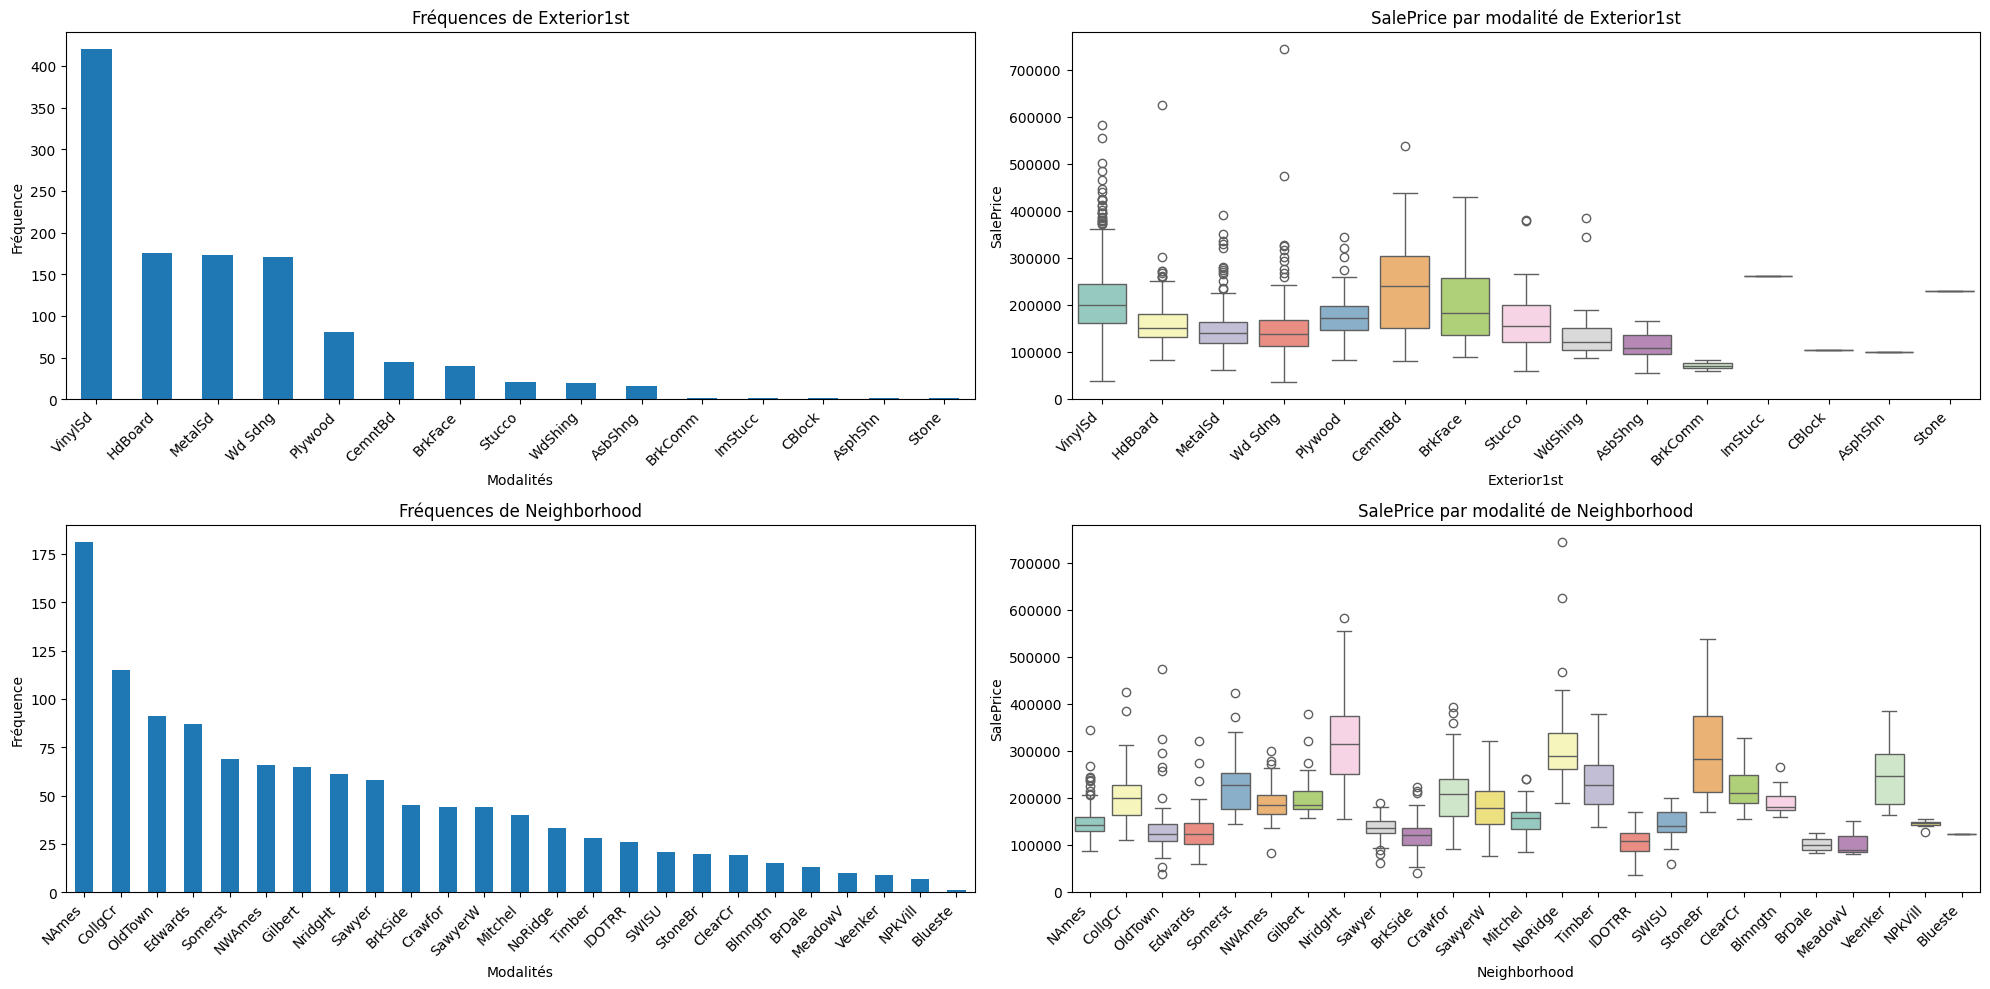

In [363]:
visualiser_variables_qualitatives(data_train, 
                                  n_o, 
                                  variable_cible='SalePrice')

#### Variable Neighborhood
Cette variable étant celle qui a le meilleur pouvoir prédictif, nous supposons que les variables de prix (moyenne) par modalité de cette dernière lui sont en grandes partie attribuable. En conséquence, elle sera recodée avec le target encoding.

In [364]:
n_o

['Exterior1st', 'Neighborhood']

In [365]:
# Calcul de la moyenne de la variable cible pour chaque catégorie de 'Pays'
mean_target = data_train.groupby('Neighborhood')['SalePrice'].mean()

# Target encoding : remplacer chaque catégorie de 'Pays' par la moyenne correspondante
data_train['Neighborhood'] = data_train['Neighborhood'].map(mean_target)

In [366]:
freq_map = data_train['Exterior1st'].value_counts(normalize=True).to_dict()

# Créer la colonne encodée  
data_train['Exterior1st'] = data_train['Exterior1st'].map(freq_map)

### Standardisation

In [367]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Appliquer le scaler aux colonnes numériques uniquement
data_train[cont+ ['SalePrice']] = scaler.fit_transform(data_train[cont+ ['SalePrice']])
    

In [368]:
va = n_o + o_num + o_n_num + cont + ['SalePrice']

In [369]:
# Copie du DataFrame original pour éviter les modifications directes
data_f = data_train.copy()

# Formatage des variables continues
for col in va:
    data_f [col] = data_f [col].astype(float)


In [370]:

merged_df = data_f[va]
train_file_path = os.path.join(dirs['output_dir'], 'xtest.csv')
merged_df.to_csv(train_file_path, index=False)